Can I automateish the line measurements?

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [227]:
linelist = Table.read('/home/david/work/muscles/SEDs/lines/FUV_linelist.csv')

In [228]:
t1data = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')

In [229]:
w, f , e = np.array(t1data['WAVELENGTH']), np.array(t1data['FLUX']), np.array(t1data['ERROR'])

In [230]:
cos_cut = (w > 1100) & (w < 1207) | (w > 1225) & (w < 1273.9) | (w > 1287.3) & (w < 1301) | (w > 1307) & (w < 3100) 
 #lya_range = [1207, 1225] #lyman alpha region to remove
  #  other_airglow =  [1273.9, 1287.3, 1301, 1307]  #oi airglow to remove

w, f, e = w[cos_cut], f[cos_cut], e[cos_cut]

In [231]:
#mw = np.arange(w[0], w[-1], 0.01)

In [232]:
high = linelist[linelist['Likelihood to measure'] =='High'] 

In [233]:
#dv = -56.3*u.km/u.s
dv = -60*u.km/u.s

In [234]:
"""
m_init = models.Const1D(0)
for line in high['Wavelength']:
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    m_init+= models.Gaussian1D(1e-16, li, 0.1, fixed=dict(mean=True, stddev=True))
    
plt.plot(mw, m_init(mw))
plt.xlim(1600, 1700)    """

"\nm_init = models.Const1D(0)\nfor line in high['Wavelength']:\n    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value\n    m_init+= models.Gaussian1D(1e-16, li, 0.1, fixed=dict(mean=True, stddev=True))\n    \nplt.plot(mw, m_init(mw))\nplt.xlim(1600, 1700)    "

In [235]:
smooth = 5
f1 = convolve(f,Box1DKernel(smooth))
e1 = convolve(e,Box1DKernel(smooth))/smooth**0.5

In [236]:
fitter = fitting.LevMarLSQFitter()

In [237]:
"""m_fit = fitter(m_init, w, f1, weights = 1/e1, maxiter=10000)"""

'm_fit = fitter(m_init, w, f1, weights = 1/e1, maxiter=10000)'

In [238]:
"""plt.plot(w, f1)
plt.plot(mw, m_fit(mw))
plt.show()

plt.plot(w, f1)
plt.plot(mw, m_fit(mw))
plt.xlim(1545, 1555)
plt.show()"""

'plt.plot(w, f1)\nplt.plot(mw, m_fit(mw))\nplt.show()\n\nplt.plot(w, f1)\nplt.plot(mw, m_fit(mw))\nplt.xlim(1545, 1555)\nplt.show()'

Alternativly: Just integrate over range and model with fixed width.

In [239]:
lines = np.array(high['Wavelength'])
names = np.array(high['Ion'])
dv_lines =  dv.to(u.AA, equivalencies=u.doppler_optical(lines*u.AA)).value

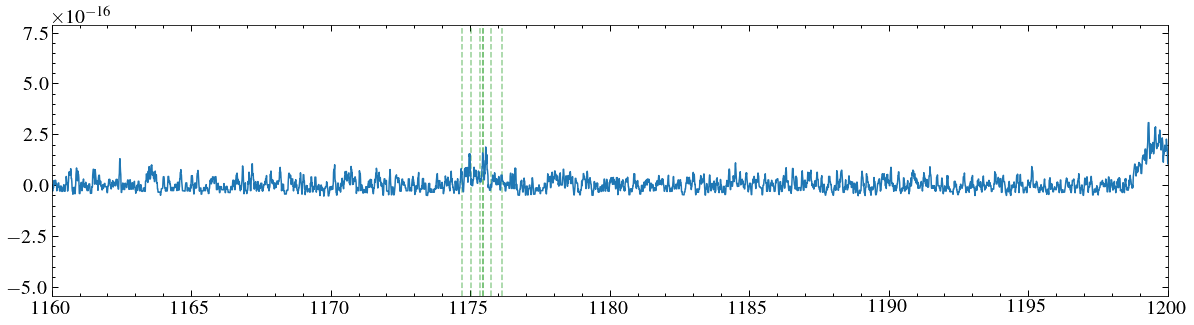

(1540.0, 1700.0)

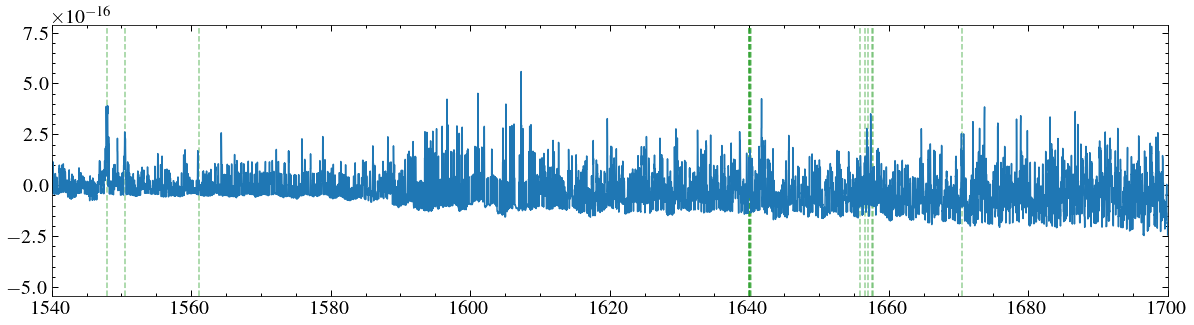

In [240]:

plt.figure(figsize=(20, 5))
[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in dv_lines]
plt.plot(w, f1)
plt.xlim(1160, 1200)
plt.show()
plt.figure(figsize=(20, 5))
[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in dv_lines]
plt.plot(w, f1)
plt.xlim(1540, 1700)

In [241]:
#combining close lines

grouped_lines = []
group = []
grouped_names = [] #double check two lines with the same name aren't being squished up
name_group = []
for i,line in enumerate(lines):
    if line - lines[i-1] < 0.9:
        group.append(line)
        name_group.append(names[i])
        
    else:
        grouped_lines.append(group)
        grouped_names.append(name_group)
        group = [line]
        name_group = [names[i]]
print(grouped_lines)
print(grouped_names)
combined_lines = []
for group in grouped_lines:
    combined_lines.append(np.mean(group))
#print(combined_lines)

[[977.022], [1037.02], [1174.935, 1175.265, 1175.592, 1175.713, 1175.713, 1175.989, 1176.372], [1206.499, 1206.499], [1238.821], [1242.804], [1264.737], [1294.543], [1298.892, 1298.944], [1301.147], [1302.169], [1303.323], [1304.369, 1304.858], [1306.029], [1323.952], [1334.524], [1335.709], [1393.755], [1402.77], [1548.201], [1550.772], [1561.438], [1640.332, 1640.345, 1640.375, 1640.391, 1640.474, 1640.49, 1640.533], [1656.267, 1657.008, 1657.379, 1657.907, 1658.122]]
[['C III'], ['C II'], ['C III', 'C III', 'C III', 'C III', 'C III', 'C III', 'C III'], ['Si III', 'Si III'], ['N V'], ['N V'], ['Si II'], ['Si III'], ['Si III', 'Si III'], ['Si III'], ['O I'], ['Si III'], ['Si II', 'O I'], ['O I'], ['C II'], ['C II'], ['C II'], ['Si IV'], ['Si IV'], ['C IV'], ['C IV'], ['C I'], ['He II', 'He II', 'He II', 'He II', 'He II', 'He II', 'He II'], ['C I', 'C I', 'C I', 'C I', 'C I']]


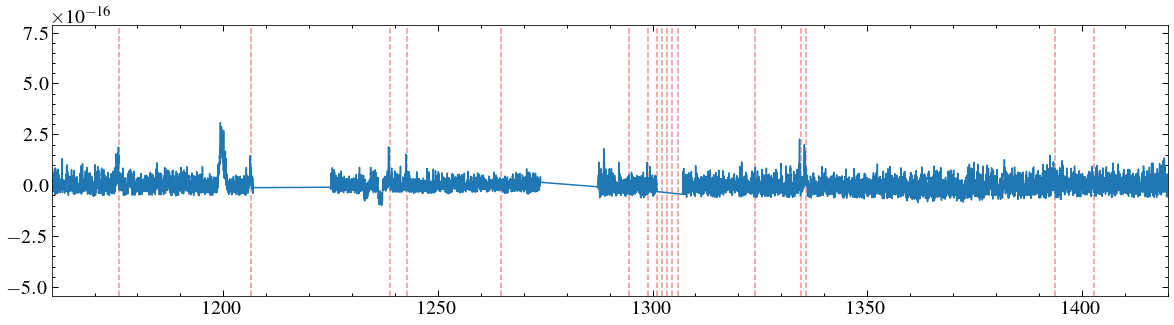

(1540.0, 1700.0)

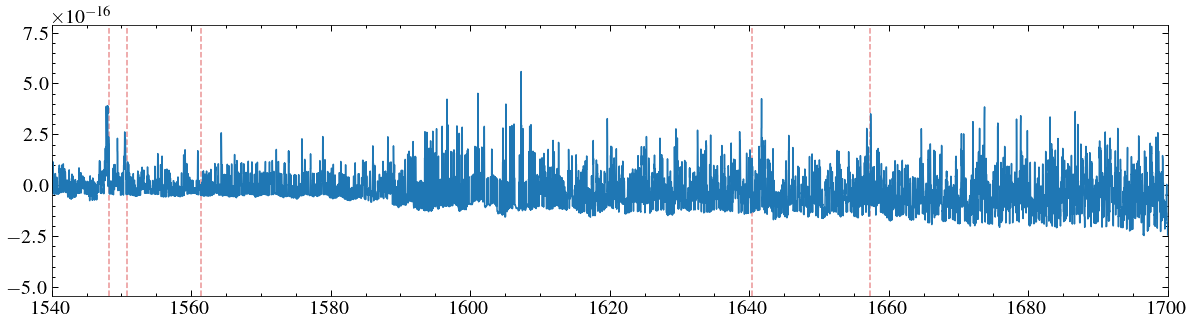

In [242]:

plt.figure(figsize=(20, 5))
#[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in dv_lines]
[plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in combined_lines]
plt.plot(w, f1)
plt.xlim(1160, 1420)
plt.show()
plt.figure(figsize=(20, 5))
#[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in dv_lines]
[plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in combined_lines]
plt.plot(w, f1)
plt.xlim(1540, 1700)

- define line ranges using highest and lowest in groups +/-0.5 A
- mask out lines to make a "continum" spectrum
- integrate over lines.
- fit to 1A? of continumum each side.
- line flux - continum flux 


2 ['C III'] 1175.418849250886 87.69303484868131 5.259559475740538


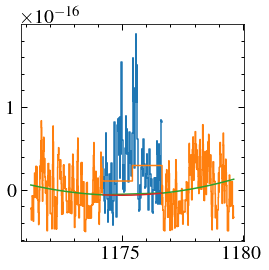

3 ['Si III'] 1206.2575331516246 37.51718134648933 3.3705350133377783


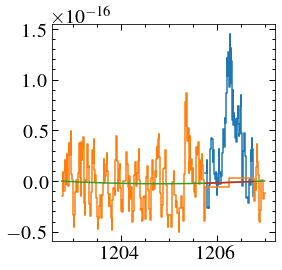

4 ['N V'] 1238.5730642764136 58.70335130969844 3.066212072592803


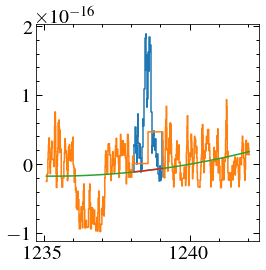

5 ['N V'] 1242.5552671249388 19.456691406952167 2.3426529836029397


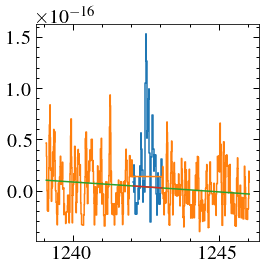

6 ['Si II'] 1264.483877488159 -2.260705163700635 1.941722749597469


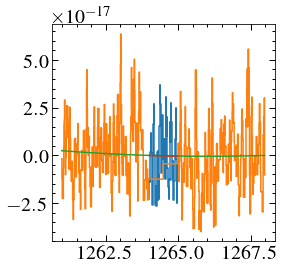

7 ['Si III'] 1294.2839121613058 -0.5284477691251935 3.379738479715909


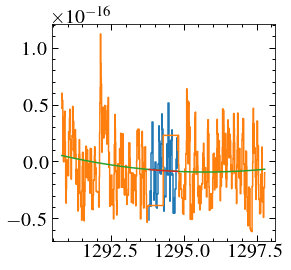

8 ['Si III'] 1298.658036555556 2.040234393093207 7.777942710602059


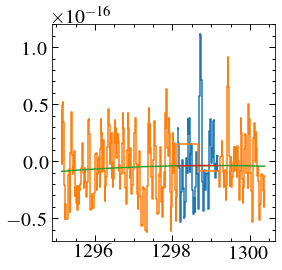

9 ['Si III'] 1300.886590446935 5.880590124964981 5.95857552565785


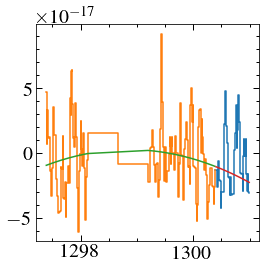

14 ['C II'] 1323.6870262894206 0.6351868917176108 4.864670795754365


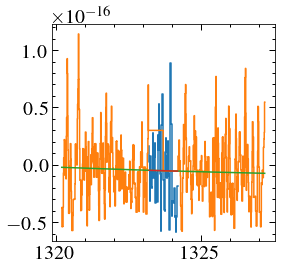

15 ['C II'] 1334.2569104256518 31.606753573054213 3.022651313246671


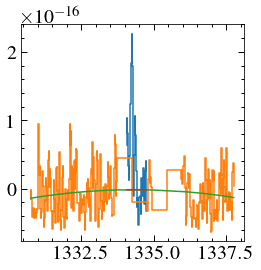

16 ['C II'] 1335.4416732615803 63.04218565570287 3.6197525881465364


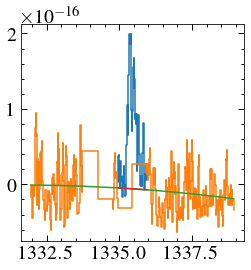

17 ['Si IV'] 1393.4760560246984 17.49111165868498 4.054679432035316


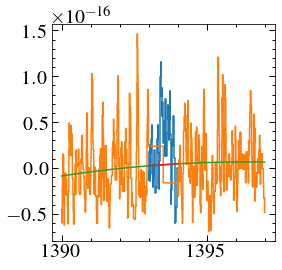

18 ['Si IV'] 1402.4892517765074 0.2524523424160001 4.571118294382038


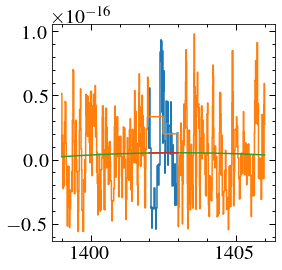

19 ['C IV'] 1547.8911454405502 108.5707302144828 9.173315014876188


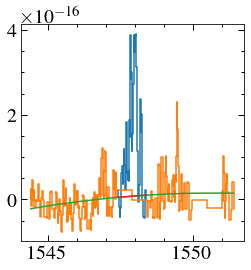

20 ['C IV'] 1550.4616308845768 52.46698282368897 6.267556147078147


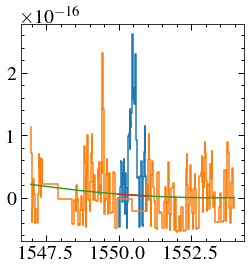

21 ['C I'] 1561.1254962077933 -5.961953526548285 3.367555771047473


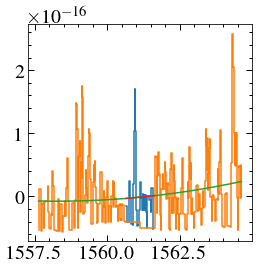

22 ['He II'] 1640.0916888721733 -29.656981410624326 10.310127166479896


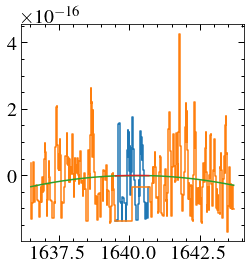

23 ['C I'] 1657.0049032099494 56.18879874089854 42.85751904749068


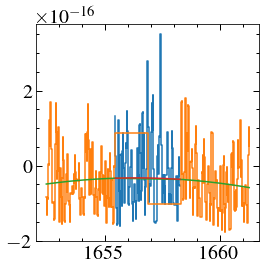

In [243]:
def wavelength_edges(w, gap=10):
    """
    Calulates w0 and w1, accounting for gaps induced by masking etc
    """
    diff = np.diff(w)
   # diff = np.insert(diff, 0, diff[0]) #adds an extravalue to make len(diff) = len(w)
    diff = np.insert(diff, (0, len(diff)), (diff[0], diff[-1])) #adds an extravalue to make len(diff) = len(w)+1
    w0 = []
    w1 = []
    for i, wi in enumerate(w):
        w0i, w1i = diff[i]/2, diff[i+1]/2
        if (max(w0i, w1i)/min(w0i, w1i)) > gap:
            w0i, w1i = min(w0i, w1i), min(w0i, w1i)
        w0.append(wi - w0i)
        w1.append(wi + w1i)
   # w0 = w - diff/2.
   # w1 = w + diff/2.
    
    return np.array(w0), np.array(w1)

def mask_maker(x, pairs, include=True):
    """
    creates a mask for a spectrum that excudes between pairs from an array
    """
    b = pairs[::2]
    r = pairs[1::2]
    C = np.zeros_like(x,dtype='bool')
    for i in range(len(b)):
        C |= (x>b[i])&(x<r[i])
    if include:
        return ~C
    else:
        return C
    
pairs = []
for group in grouped_lines:
    group =  dv.to(u.AA, equivalencies=u.doppler_optical(group*u.AA)).value
    pairs.append(min(group)-0.5)    
    pairs.append(max(group)+0.5)

mask = mask_maker(w, pairs)
cw, cf, ce = w[mask], f1[mask], e1[mask]

line_names = []
line_means = []
line_fluxes = []
line_errors = []

for i, group in enumerate(grouped_lines):
    rest_group = group
    #print(group)
    group =  dv.to(u.AA, equivalencies=u.doppler_optical(group*u.AA)).value
    #print(group)
    
    be = 0.5
    if i ==15:
        be = 0.2 #cut noise spike in si 4
    linemask = (w > min(group)-be) & (w < max(group)+0.5)
    contmask = (cw > min(group)-3.5) & (cw < min(group)-0.5) | (cw > max(group)+0.5) & (cw < max(group)+3.5)
    lw, lf, le = w[linemask], f1[linemask], e1[linemask]
   # print(len(lw))
    if len(lw) >10:
        cfit = np.polyfit(cw[contmask], cf[contmask], 2)
        w0, w1 = wavelength_edges(lw)
        lineflux = np.sum((w1-w0)*lf)
        line_error = (np.sum(le**2 * (w1-w0)**2))**0.5
        cflux = np.sum((w1-w0)*np.polyval(cfit, lw))
        cerror = (line_error/abs(lineflux))*abs(cflux)
        flux = lineflux - cflux
        flux_error = (line_error**2+cerror**2)**0.5
        print(i, np.unique(grouped_names[i]), np.mean(group), flux*1e18,flux_error*1e18)
        line_fluxes.append(flux)
        line_errors.append(flux_error)
        line_names.append(np.unique(grouped_names[i]))
        line_means.append(np.mean(rest_group))
        
        plt.figure(figsize=(4,4))
        plt.step(lw, lf, where='mid')
        plt.step(cw[contmask], cf[contmask], where='mid')
        plt.plot(cw[contmask], np.polyval(cfit, cw[contmask]))
        plt.plot(lw[1:], np.polyval(cfit, lw[1:]))
        
        #flux = ((2*np.pi)**0.5) * amp * std
       # print(len(group), flux/len(group))
        #mod_std = 0.1
        #model_amp =  (flux/len(group)) / (mod_std*((2*np.pi)**0.5)) 
       # print(model_amp)
        #model = models.Gaussian1D(model_amp, group[0], mod_std)
        #if len(group) > 1:
         #   for li in group[1:]:
       #         model = model + models.Gaussian1D(model_amp, li, mod_std)
        #plt.plot(lw, model(lw))
        
        plt.show()


In [244]:
2 ['C III'] 1175.418849250886 87.69303484868131 5.259559475740538
3 ['Si III'] 1206.2575331516246 37.51718134648933 3.3705350133377783
4 ['N V'] 1238.5730642764136 58.70335130969844 3.066212072592803
5 ['N V'] 1242.5552671249388 19.456691406952167 2.3426529836029397
6 ['Si II'] 1264.483877488159 -2.260705163700635 1.941722749597469
7 ['Si III'] 1294.2839121613058 -0.5284477691251935 3.379738479715909
8 ['Si III'] 1298.658036555556 2.040234393093207 7.777942710602059
9 ['O I' 'Si II' 'Si III'] 1302.9123849263935 -2.457797974062651 2.4285131503833663
11 ['C II'] 1323.6870262894206 0.6351868917176108 4.864670795754365
12 ['C II'] 1334.2569104256518 37.61968597477402 3.559103819522662
13 ['C II'] 1335.4416732615803 63.04218565570287 3.6197525881465364
14 ['Si IV'] 1393.4760560246984 17.49111165868498 4.054679432035316
15 ['Si IV'] 1402.4892517765074 7.813960484605279 3.066904696168464
16 ['C IV'] 1547.8911454405502 108.5707302144828 9.173315014876188
17 ['C IV'] 1550.4616308845768 52.46698282368897 6.267556147078147
18 ['C I'] 1561.1254962077933 -5.961953526548285 3.367555771047473
19 ['He II'] 1640.0916888721733 -29.656981410624326 10.310127166479896
20 ['C I'] 1657.0049032099494 56.18879874089854 42.85751904749068


SyntaxError: invalid syntax (<ipython-input-244-3c2fd37d0791>, line 1)

In [ ]:
def Round_n_sig_dig(x, n):

    import numpy as np               
    xr = (np.floor(np.log10(np.abs(x)))).astype(int)
    xr=10.**xr*np.around(x/10.**xr,n-1)   
    return xr

In [ ]:
def name_to_ion(name, aas=True): #takes a name from Girish's table and turns it into a latex ion command
    el = name[0:(name.find(' '))]
    ion = name[(name.find(' '))+1:].lower()
    #apj needs numbers not numerals, eaiser to hardcode
    if aas:
        numerals = np.array(['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x'])
        ion = np.where(numerals==ion)[0][0]+1
    return '\ion{{{}}}{{{}}}'.format(el, ion)
    
    
    
for n, l, fl, el in zip(line_names, line_means, line_fluxes, line_errors):
    if len(n) == 1:
        ion_name = name_to_ion(n[0])
        fl = Round_n_sig_dig(fl*1e18, 2)
        el = Round_n_sig_dig(el*1e18, 2)
        if  fl < el:
                value = '$\leq{0}$'.format(el)
        else:

            value = '${0}\pm{1}$'.format(fl, el)
        print ('{} & {} & {} \\\\'.format(ion_name, l, value))


Deleting first and last points does have an effect- need to use w0, w1.

Test getting observed dv off the strongest lines? See if C4 lines are strongest for whole sample? Cii1334 lines are popular

In [ ]:
def tiedfunc0(gg_init):
   # mean = gg_init.mean_1.value + 1.185
   # mean = gg_init.mean_1.value + 3.983
    mean = gg_init.mean_1.value + 2.571
    return mean

smooth = 10
f2 = convolve(f,Box1DKernel(smooth))
e2 = convolve(e,Box1DKernel(smooth))/smooth**0.5

fitter = fitting.LevMarLSQFitter()
#lines = [1334.524, 1335.709]
#lines = [1238.821, 1242.804]
lines = [1548.201,1550.772]

mask = (w > lines[0]-4) & (w < lines[1]+4) 
plt.step(w[mask], f2[mask], where='mid')
plt.step(w[mask], e2[mask], where='mid')


dv_guess = -60*u.km/u.s
lw, lf, le = w[mask], f2[mask], e2[mask]

print(np.diff(lines))


lines_guess = dv_guess.to(u.AA, equivalencies=u.doppler_optical(lines*u.AA)).value
print(np.diff(lines_guess))

amp_guess = np.max(lf)
gg_init = models.Polynomial1D(2) + models.Gaussian1D(amp_guess, lines_guess[0], 0.05) + models.Gaussian1D(amp_guess, lines_guess[1], 0.05)
gg_init.mean_2.tied=tiedfunc0
gg_fit = fitter(gg_init, lw, lf, weights=1/le, maxiter=10000)

plt.plot(lw, gg_fit(lw))

dv1 = (gg_fit[1].mean*u.AA).to(u.km/u.s, equivalencies=u.doppler_optical(lines[0]*u.AA))
print(dv1)
dv2 = (gg_fit[2].mean*u.AA).to(u.km/u.s, equivalencies=u.doppler_optical(lines[1]*u.AA))
print(dv2)
print(gg_fit[2].mean-gg_fit[1].mean)
print(gg_fit)

In [ ]:
dvs = [-60.10439953926004,-59.9117739737697,-63.00027824386286,-62.944386332047486,-56.4010118415698,-56.307505509593504]

lines = [1238.821, 1242.804, 1334.524, 1335.709, 1548.201,1550.772]

plt.plot(lines, dvs)
np.mean(dvs[0:2])

Is the Si IV affected by ISM?

In [ ]:
def tiedfunc0(gg_init):
    mean = gg_init.mean_1.value + 9.015
    return mean

smooth = 10
f2 = convolve(f,Box1DKernel(smooth))
e2 = convolve(e,Box1DKernel(smooth))/smooth**0.5

fitter = fitting.LevMarLSQFitter()
lines = [1393.755, 1402.77]

mask = (w > lines[0]-4) & (w < lines[1]+4) 
plt.step(w[mask], f2[mask], where='mid')
plt.step(w[mask], e2[mask], where='mid')


dv_guess = -60*u.km/u.s
lw, lf, le = w[mask], f2[mask], e2[mask]

print(np.diff(lines))


lines_guess = dv_guess.to(u.AA, equivalencies=u.doppler_optical(lines*u.AA)).value
print(np.diff(lines_guess))

[plt.axvline(line, ls='--', C='C3') for line in lines]
[plt.axvline(line, ls='--', C='C4') for line in lines_guess]

amp_guess = np.max(lf)
gg_init = models.Polynomial1D(2) + models.Gaussian1D(amp_guess, lines_guess[0], 0.05) + models.Gaussian1D(amp_guess, lines_guess[1], 0.05)
gg_init.mean_2.tied=tiedfunc0
gg_fit = fitter(gg_init, lw, lf, weights=1/le, maxiter=10000)

plt.plot(lw, gg_fit(lw))

dv1 = (gg_fit[1].mean*u.AA).to(u.km/u.s, equivalencies=u.doppler_optical(lines[0]*u.AA))
print(dv1)
dv2 = (gg_fit[2].mean*u.AA).to(u.km/u.s, equivalencies=u.doppler_optical(lines[1]*u.AA))
print(dv2)
print(gg_fit[2].mean-gg_fit[1].mean)
print(gg_fit)

Ok too fast for ISM, just mask that bit?